<a href="https://colab.research.google.com/github/mrribbits/neu350/blob/main/08_2_fMRI_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fMRI Session 02

In this exercise you will explore fMRI data from an experiment performed here at PNI, to evaluate how well the BOLD response to a visual stimulus is specific to the visual cortex (V1/V2).

<font color="orange">Version 2022-02-16.</font>
<font color="orange"><br>Version 2024-04-08. Migrating away from SZ github</font>
<font color="orange"><br>Version 2024-04-09. Added an additional figure idea.</font>

<small>written by Sam Zorowitz. Adapted for colab and expanded by AA & RB</small>

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

In today's demonstration, we will show you how to generate the predicted Blood-Oxygen-Level-Dependent (BOLD) signal of a simple block design fMRI experiment. In fact, we will be making the predicted BOLD signal for an experiment run by a couple of PNI graduent students a few years ago.

Today we will be conducting three things:
- Part 1: Loading and viewing fMRI data
- Part 2: Filtering and calculating percentage signal change of our data
- Part 3: Building a design matrix and running least squares regression
- Part 4: Looking at how well our model did
- Part 5: Inspecting signals in defined regions of interest (ROIs; here, visual cortex V1/V2)

*Note 1: this notebook has you handle data that are of more dimensions than you are probably used to. It is always useful to check what your variables' dimensions are by checking their shapes (use the `.shape` operator in numpy)*

*Note 2: whenever you see <font color="dodgerblue">this color</font> know that you are expected to write code in the next code block to proceed*



## Section 1: Load and inspect the fMRI data

In this first section, we will load and inspect fMRI data from one participant. As a reminder, this participant completed an experiment where they watched alternating blocks of a [visual checkerboard](https://www.youtube.com/watch?v=xEd1h_lz4rA) (warning: flashing lights) and an empty black background. Each stimulus (i.e. checkerboard, blank screen) was presented for 20 seconds a time.

We will use a new python package, `nibabel`, to open this participant's raw data file.

*Note: There is nothing special about the data structure stored in `func` once it is loaded. It is a numpy array that you are familiar with handling already!*

In [101]:
import nibabel as nib

!wget -nv https://github.com/mrribbits/neu350/blob/main/sample_data/sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz?raw=true
!mv sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz?raw=true sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz

# Specify path to file.
f = 'sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz'

## Load functional data.
func_allslices = nib.load(f).get_fdata()
print('Functional data dim:\t(X=%s, Y=%s, Z=%s, T=%s)' %func_allslices.shape)

2025-03-06 04:27:13 URL:https://raw.githubusercontent.com/mrribbits/neu350/refs/heads/main/sample_data/sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz [43851311/43851311] -> "sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-preproc_bold.nii.gz?raw=true" [1]
Functional data dim:	(X=57, Y=66, Z=57, T=120)


As the data's dimensions note, the data is a 4d tensor (a matrix of more than 2 dimensions!): three spatial dimensions and time. The x-axis defines the space between the left to right hemispheres. The y-axis defines the space from anterior to posterior (front to back). The z-axis defines the space from dorsal to ventral (top to bottom). Each element of this matrix is known as a **voxel**, or a 3d pixel, and is a measurement of the BOLD response at a given point and time during the scan. For this scan, each voxel was $2.5 \text{mm}^3$.

As you may have noticed, the z-axis is only one voxel deep. To simplify the analysis today, you will be analyzing only one **axial slice** (i.e. one horizontal slice) of this participant's brain.

Let's begin by inspecting the brain. We can do this averaging over all time points (i.e. the 4th dimension). After averaging (and squeezing), use either Matplotlib's (`plt.imshow`) or Seaborn's (`sns.heatmap`) heatmap function to visualize the brain. We recommend setting `cmap=binary_r` for best results.

Avg slice data dim:	(X=57, Y=66)


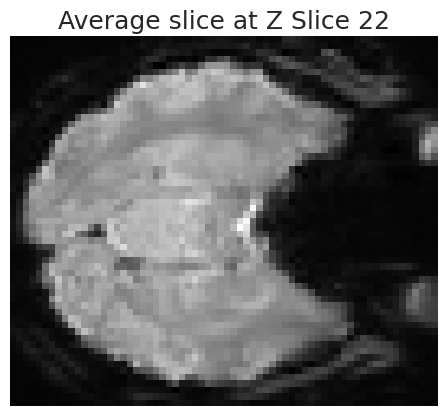

Extracted slice shape (X, Y, Z, T): (57, 66, 1, 120)


In [155]:
## Average and squeeze.
avg3d = func_allslices.mean(axis=-1).squeeze()

import matplotlib.pyplot as plt

## Choose a slice from the Z-axis (e.g., slice 22)
slice_idx = 22
## Extract the slice as its own 2D array from the Z-axis (e.g., slice 22)
avgslice = avg3d[:, :, slice_idx]

## View dimensions of the averaged slice:
print(f'Avg slice data dim:\t(X={avgslice.shape[0]}, Y={avgslice.shape[1]})')

## Plot (using seaborn)
sns.heatmap(avgslice, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);
plt.title(f'Average slice at Z Slice {slice_idx}')
plt.show()

## Extract the same Z slice as its own 3D array (X,Y,Z,T):
func = func_allslices[:, :, slice_idx, :]
func = np.expand_dims(func, axis=2)   ## Add the Z dimension with size 1, so shape becomes (X, Y, 1, T)

## View dimensions of the extracted slice (X, Y, T):
print(f"Extracted slice shape (X, Y, Z, T): {func.shape}")

In the image above, can you find the visual cortex? (Hint: in raw, unmasked fMRI data, the eyeballs are still visually prominent.)

The image above suggests we need to perform **masking**. That is, we need to remove the voxels corresponding to (oxygen-rich) non-neural tissues including the eyes and skull layers. Fortunately for us, we have a brain-only binary mask for this participant. The mask was created during the process known as **skull-stripping** (i.e. digital removal of non-neural tissues).

We load in this image below.

2025-03-06 05:12:50 URL:https://raw.githubusercontent.com/mrribbits/neu350/refs/heads/main/sample_data/sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz [9706/9706] -> "sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz?raw=true" [1]
Mask slice dim: (57, 66, 1)


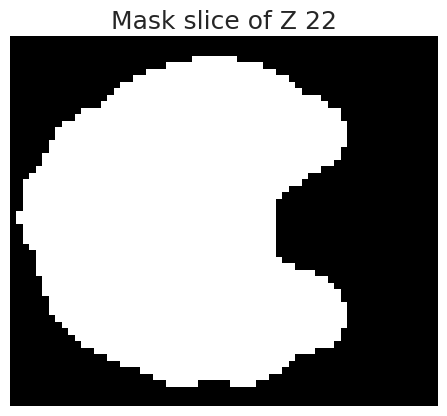

In [156]:
!wget -nv https://github.com/mrribbits/neu350/blob/main/sample_data/sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz?raw=true
!mv sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz?raw=true sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz

## Specify path to file.
mask3d = 'sub-999_ses-01_task-fullfieldstimulus_run-2_space-T1w_desc-brain_mask.nii.gz'

## Load files.
mask3d = nib.load(mask3d).get_fdata()

## Extract the same slice for the mask as we did earlier for the functional data:
mask_slice = mask3d[:, :, slice_idx]
mask_slice = np.expand_dims(mask_slice, axis=2)   ## Add the Z dimension with size 1, so shape becomes (X, Y, 1, T)

## View dimensions of the mask slice and view the mask:
print(f"Mask slice dim: {mask_slice.shape}")

## To view it the mask slice, you have to remove the z dimension so that it is 2D:
# Extract 2D mask slice from 3D mask_slice
mask_slice_2d = mask_slice[:, :, 0]  # This removes the third dimension (Z=1)
sns.heatmap(mask_slice_2d, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[])
plt.title(f'Mask slice of Z {slice_idx}')
plt.show()


As you can see, the mask slice is the same spatial dimensions as the earlier functional data slice. Now let's use the mask to remove non-brain voxels from our functional data slice and plot it.

Original mask shape: (57, 66, 1)
Original functional data shape: (57, 66, 1, 120)
Masked functional data shape: (57, 66, 1, 120)


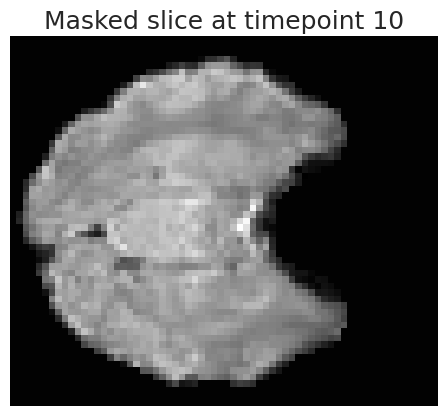

In [157]:
# Assuming `mask_slice` has the shape (X, Y, Z)
# And `func` has the shape (X, Y, Z, T)
print(f"Original mask shape: {mask_slice.shape}")
print(f"Original functional data shape: {func.shape}")

## Broadcasting the mask across the T dimension and multiplying with the functional data:
masked_func = func * mask_slice[..., np.newaxis]  # Only add a new axis for T (to match func)

# Check the dimensions of the newly created masked functional data (should be (X, Y, Z, T))
print(f"Masked functional data shape: {masked_func.shape}")

# Specify a timepoint you want to view (e.g., timepoint 10)
timepoint_idx = 10

## To view the masked timepoint, you have to remove the z dimension so that it is 2D:
slice_at_timepoint = masked_func[:, :, 0, timepoint_idx]  # This removes the third dimension (Z=1)
sns.heatmap(slice_at_timepoint, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[])
plt.title(f'Masked slice at timepoint {timepoint_idx}')
plt.show()


The masked functional data slice looks good! The skull layers and eyes have been successfully removed. We will use this image going forward.

## Section 2: Filtering and Percent Signal Change

Just like electrophysiological data, fMRI data is also usually filtered prior to analysis. Highpass filtering fMRI data is useful as it removes low frequency drifts in the fMRI signal. (For a great overview of sources of noise in fMRI data, see [Greve et al., 2013](https://doi.org/10.1007/s11336-012-9294-0).) Highpass filtering can be performed in a number of ways, but thankfully `nilearn` makes this very easy for us. We will use the `clean` function to highpass filter the data. The appropriate frequency cutoff may depend on your particular experiment, but standard values are 1/100 (0.01) Hz, 1/128 Hz (0.0078), and 1/200 (0.005) Hz.

Importantly, applying a highpass filter will demean our data (i.e. subtract the mean from each voxel). This is not ideal if we are interested in converting our data to percent signal change ([Chen et al. 2017](https://www.sciencedirect.com/science/article/pii/S1053811916305432)). Thus, we will store the mean intensities of each voxel prior to filtering.



In [78]:
#Install nilearn if not installed already
!pip install nilearn==0.9

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 1.8 MB/s eta 0:00:00


In [158]:
import numpy as np
from nilearn.signal import clean

## Define filtering parameters.
high_pass = 1 / 100.  # High-pass filter threshold
tr = 1  # Repetition time (TR)

## Reshape the data for filtering.
nx, ny, nz, nt = func.shape
raw = func.reshape(-1, nt).T  # Reshaping to (T, X*Y*Z)

## Compute mean signal.
mu = raw.mean(axis=0)

# Check if any of the mean values are zero and replace them with a small constant.
mu[mu == 0] = 1e-10  # Replace zero with a small value to avoid division by zero

## Apply high-pass data.
filt = clean(raw, detrend=True, standardize=False, high_pass=high_pass, t_r=tr)

## Convert to percent signal change.
filt = filt / mu * 100  # Calculate percent signal change

## Shape back into original dimensions.
filt = filt.T.reshape(nx, ny, nz, nt)

# Check the result
print(f"Filtered data shape: {filt.shape}")

Filtered data shape: (57, 66, 1, 120)


Let's inspect the filtered brain. average over all the time points (i.e. the 4th dimension) of the new matrix `filt`. After averaging (and squeezing), make a heatmap of the averaged image. How does the image look now?

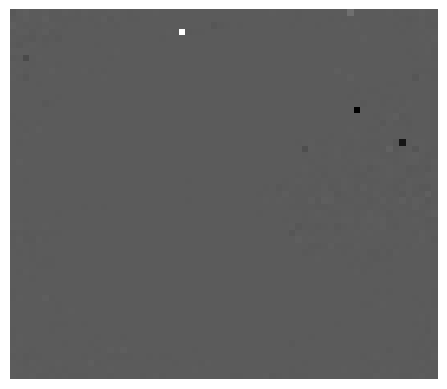

In [159]:
## Average and squeeze.
avg = filt.mean(axis=-1).squeeze()

## Plot.
sns.heatmap(avg, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);

If the brain is harder to see now, that's good! That's because what normally separates the brain from the background image is the average voxel intensity (average BOLD signal) which is much higher in biological tissue. After filtering, however, we've demeaned and normalized the brain so that this average intensity has been removed. This is helpful for our analysis because it now makes measurements of BOLD signal change comparable across the brain.

Let's now use our brain mask to mask all voxels not corresponding to neural tissue. Use the brain mask to index into `filt` and set all non-neural voxels (i.e. all voxels in `mask` with a value less than one) to zero.

In [166]:
print(f"filt: {filt.shape}")
print(f"mask: {mask_slice.shape}")

## Ensure the mask is boolean (True for neural tissue, False for non-neural tissue)
mask_boolean = mask_slice > 0  # Assuming mask has values > 0 for brain tissue

## Expand the mask to match the shape of filt
mask_expanded = mask_boolean[..., np.newaxis]  # Shape becomes (X, Y, Z, 1)

## Broadcast the mask to match the time dimension (filt.shape)
mask_expanded = np.broadcast_to(mask_expanded, filt.shape[:3] + (filt.shape[3],))  # Shape becomes (X, Y, Z, T)

## Apply the mask to the filtered data (set non-brain voxels to 0)
filt[~mask_expanded] = 0  # This sets all voxels that are not brain tissue to 0

## Check the result (dimensions of filt should remain the same)
print(f"Masked filtered data: {filt.shape}")

filt: (57, 66, 1, 120)
mask: (57, 66, 1)
Masked filtered data: (57, 66, 1, 120)


<font color="dodgerblue">To confirm that this procedure worked, remake the image from the step above. It should be easier now to tell brain from non-brain.</font>

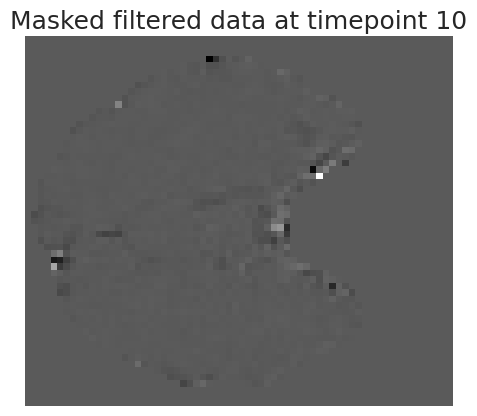

In [165]:
## To view the masked filtered data, you have to remove the z dimension so that it is 2D:
filt_as_2D = filt[:, :, 0, timepoint_idx]  # This removes the third dimension (Z=1)
sns.heatmap(filt_as_2D, cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[])
plt.title(f'Masked filtered data at timepoint {timepoint_idx}')
plt.show()

## Section 3: Design Matrix & Regression

In this step, similar to what you did last time, we will make the predicted BOLD signal in response to our alternating visual checkerboard stimulus. Now that you know how to make the predicted BOLD signal, we will not have you repeat every step. Instead, we will have you use a new function, `fmritools.design.design_matrix`, that will generate the BOLD timeseries for you.

Importantly, the function `design_matrix` requires three important pieces of information: (1) the repetition time (TR), or length of time to collect one image, (2) the total number of images collected, and (3) a 3-column matrix, `events`, where each column corresponds to a stimulus onset, offset, and condition, respectively.

Fortunately, you have all of this information! We know the TR=2, and from above, we know our data has T=120 total timepoints. From last session, you know the event onsets and offsets. **Important:** For this participant's data, the first checkerboard stimulus appeared 20s after the start of the scan. That is, all of your onsets/offsets from last time should be shifted forwards by 20s.

<font color="dodgerblue">Make the 3-column `events` matrix, where the first column is *onsets*, the second column is *offsets*, and the third column is an array of ones.</font>

In [178]:
## Define events.
onsets = np.array([20, 60, 100, 140, 180, 220])  # Example onsets, you should replace with actual values
offsets = np.array([40, 80, 120, 160, 200, 240])  # Example offsets, adjust accordingly
conds = [1,1,1,1,1,1]

events = np.column_stack([onsets, offsets, conds])

print("Events Matrix:\n", events)

Events Matrix:
 [[ 20  40   1]
 [ 60  80   1]
 [100 120   1]
 [140 160   1]
 [180 200   1]
 [220 240   1]]


Now we will generate our design matrix. Note, we are also having the `design_matrix` function return our generated boxcar function for comparison.

In [170]:
## Install fmritools if not already installed
!pip install git+https://github.com/neu350/fMRI.git

  Cloning https://github.com/neu350/fMRI.git to /tmp/pip-req-build-9nwrtqct
  Running command git clone --filter=blob:none --quiet https://github.com/neu350/fMRI.git /tmp/pip-req-build-9nwrtqct
  Resolved https://github.com/neu350/fMRI.git to commit fe8adac3fcf51b5aba3215997afa7eb6073ed52c
  Preparing metadata (setup.py) ... done
  Created wheel for fmritools: filename=fmritools-0.2-py3-none-any.whl size=11878 sha256=7e2f5a2cb52183b41afb4f37e956d952735d92863348067b05d51a94dcc0b9e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-bv_yicqr/wheels/04/b2/33/b9a2b14b150458f83573efd643a0ba0773daf8978c2f34e36c
Successfully built fmritools


In [179]:
from fmritools.design import design_matrix

## Define task metadata.
n_acq = 120
tr = 2

## Make design matrix.
times, bold, boxcars = design_matrix(tr, n_acq, events, return_boxcars=True)

<font color="dodgerblue">To confirm that the function worked, plot the boxcar function and predicted BOLD signal on the same plot.</font>



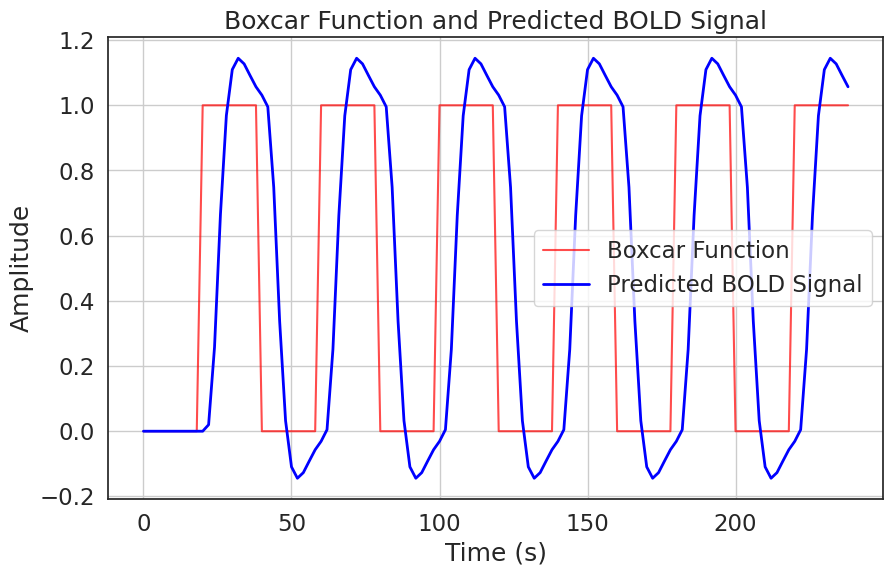

In [180]:
# Plotting the boxcar function and predicted BOLD signal.
plt.figure(figsize=(10, 6))
plt.plot(times, boxcars, label='Boxcar Function', color='r', alpha=0.7)
plt.plot(times, bold, label='Predicted BOLD Signal', color='b', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Boxcar Function and Predicted BOLD Signal')
plt.legend()
plt.grid(True)
plt.show()

The moment has arrived! We will now regress our predicted BOLD signal against our participant's observed BOLD signal.

<font color="dodgerblue">Like last time, we need to construct our design matrix, `X`. Our design matrix will be comprised of two arrays: an *intercept* and `bold` timeseries. The intercept is just an array made entirely of 1s. Using `np.ones_like` and `np.column_stack`, make our design matrix `X` in the cell below.</font>

In [181]:
import numpy as np

# Assuming you already have the predicted BOLD signal in 'bold' from previous steps

# Create the intercept column (array of ones)
intercept = np.ones_like(bold)

# Stack intercept and predicted BOLD signal to create the design matrix X
X = np.column_stack([intercept, bold])

# Check the design matrix shape
print(f"Design matrix X shape: {X.shape}")
print(f"Design matrix X:\n{X}")

Design matrix X shape: (120, 2)
Design matrix X:
[[ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.        ]
 [ 1.          0.01989536]
 [ 1.          0.25790229]
 [ 1.          0.66509109]
 [ 1.          0.96879668]
 [ 1.          1.1096215 ]
 [ 1.          1.14432323]
 [ 1.          1.12707707]
 [ 1.          1.091535  ]
 [ 1.          1.05679456]
 [ 1.          1.03107509]
 [ 1.          0.99532769]
 [ 1.          0.74883962]
 [ 1.          0.33760906]
 [ 1.          0.03215591]
 [ 1.         -0.10936419]
 [ 1.         -0.14432323]
 [ 1.         -0.12707707]
 [ 1.         -0.091535  ]
 [ 1.         -0.05679456]
 [ 1.         -0.03107509]
 [ 1.          0.00467231]
 [ 1.          0.25116038]
 [ 1.          0.66239094]
 [ 1.          0.96784409]
 [ 1. 

Let's perform regression! Note, we need to reshape our **filtered** data into a matrix so that each voxel is a row (timepoints in columns). This is done in order to regress our design matrix against every voxel in our participant's brain slice simultaneously.

*Once you are done with calculating coefficients, you need to reshape them back to your original dimensions of your fMRI data for visualization!*

In [182]:
filt.shape

(57, 66, 1, 120)

In [184]:
## Define image dimensions.
nx, ny, nz, nt = filt.shape

## Perform regression.
coef, _, _, _ = np.linalg.lstsq(X,filt.reshape(-1,nt).T,rcond=-1)

intercept_coef = coef.T.reshape(nx,ny,nz,-1)[...,0]

## Reshape regression coefficients.
coef = coef.T.reshape(nx,ny,nz,-1)[...,-1]

Now let's plot the regression coefficients. They will be easier to interpret if we overlay them on top of an image. To do this, we will make two heatmaps in the same subplot: first the brain image, then the regression coefficients. Importantly, we will threshold the coefficients such that values beneath the threshold will not be visualized.

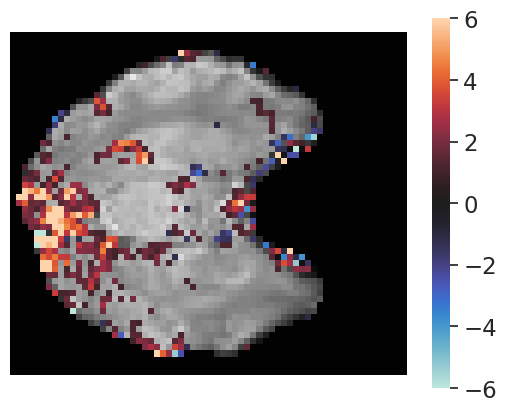

In [190]:
## Define threshold.
threshold = 1

## Mask coefficients.
viz = np.where(np.abs(coef) > threshold, coef, np.nan)

## Plot.
sns.heatmap(slice_at_timepoint.squeeze(), cmap='binary_r', cbar=False, square=True, xticklabels=[], yticklabels=[]);
sns.heatmap(viz.squeeze(), vmin=-6, vmax=6, center=0, square=True, xticklabels=[], yticklabels=[]);

Questions to ponder:
1. The units of the coefficients are in percent signal change. What does this mean? What does a threshold of 1 mean?
2. Is there one area of the brain that seems more active (i.e. greater change in BOLD signal)? Is this in line with your expectations?
3. Are there any areas that have suppressed BOLD activity following checkerboard presentation?

## Section 4: Inspecting the model

By now, it should be clear that this task robustly activates visual cortex. This is unsurprising: that's exactly what visual checkerboards are good at!

Let's extract the BOLD signal from voxels strongly activated by the task. To do this mask, use the `coef` matrix to index into the `filt` timeseries.


<font color="dodgerblue">Extract all voxels from `filt` with a corresponding coefficients greater than 5 (more than 5 percent change).</font>

In [191]:
# coefficients > 5 (for 5% change)
threshold = 5

# Create a boolean mask where coefficients are greater than 5
coef_mask = coef > threshold

# Extract the corresponding voxels from the filtered data
extracted_voxels = filt[coef_mask]

# View the result
print(f"Number of extracted voxels: {extracted_voxels.size}")
print(f"Extracted voxel values: {extracted_voxels[:10]}")  # Print first 10 extracted values for inspection

Number of extracted voxels: 5400
Extracted voxel values: [[ 1.02580036e+01 -8.49366514e+01  5.12523832e+01 ... -5.76611793e+01
  -1.04358673e+02 -4.44523111e+00]
 [ 8.41861725e-01  6.52197298e+00  6.78174635e+00 ... -1.33096914e-01
   4.68017012e-01 -2.48604924e+00]
 [-1.92224190e+01 -3.72681693e+02 -3.24875023e+02 ...  2.04696710e+02
   2.60480788e+02 -5.83748562e+00]
 ...
 [ 7.83938449e-01  1.94493835e+00 -2.95202566e-01 ... -4.58560889e+00
  -5.05881795e+00 -3.45217461e+00]
 [ 7.12704920e-01  1.39933366e+00  2.14625550e+00 ... -2.40551868e+00
  -3.39552531e+00 -2.58473506e+00]
 [ 1.09248015e+00  1.18371044e+00  2.26133556e+00 ... -4.60567408e+00
  -4.71429795e+00 -3.66121923e+00]]


<font color="dodgerblue">Now, average over each voxel in this new matrix and plot the resulting timeseries together with your idealized bold response and/or boxcars. Are they similar?</font>

filt shape: (57, 66, 1, 120)
mask shape: (57, 66, 57)
Reshaped mask shape: (57, 66, 1)
Flattened mask shape: (3762,)
Reshaped voxel data shape: (3762, 120)


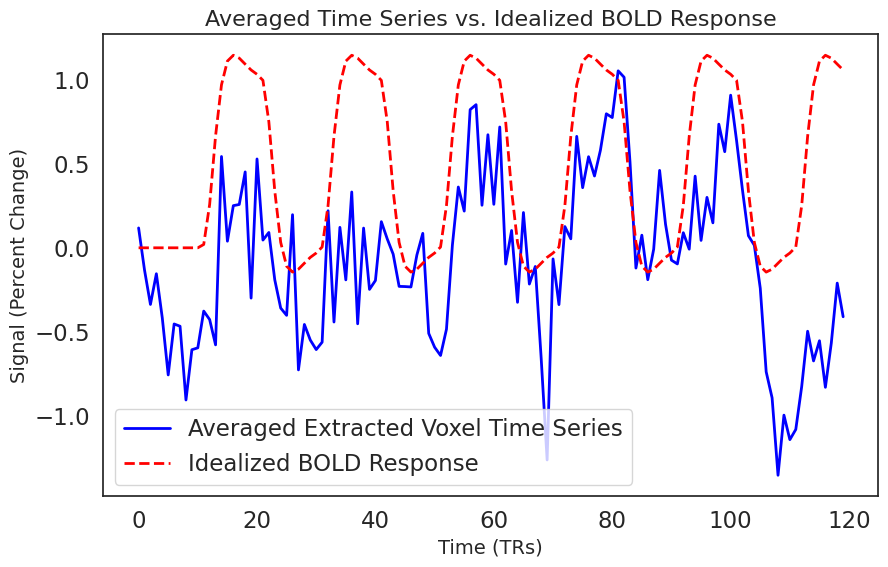

In [196]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Check the shapes of the data
print(f"filt shape: {filt.shape}")
print(f"mask shape: {mask.shape}")

# Ensure the mask is reshaped to match the shape of the functional data (filt)
# Since we're working with a single Z slice, we reshape the mask to (57, 66, 1)
mask_reshaped = mask[:, :, slice_idx]  # Slice out the relevant slice, shape (57, 66)
mask_reshaped = mask_reshaped[..., np.newaxis]  # Add the Z dimension (1)

# Now the mask shape should be (57, 66, 1), matching the X, Y dimensions of 'filt'
print(f"Reshaped mask shape: {mask_reshaped.shape}")

# Step 2: Flatten the mask and the functional data to align with the number of voxels
num_voxels = np.prod(filt.shape[:3])  # Total number of voxels (57 * 66 * 1)
voxels_reshaped = filt.reshape(num_voxels, -1)  # Reshape to (num_voxels, T)

# Flatten the mask to a 1D boolean array (True for relevant voxels, False for others)
mask_boolean = mask_reshaped.reshape(-1) > 0  # Flatten the mask and make it boolean

# Check if the shapes match
print(f"Flattened mask shape: {mask_boolean.shape}")
print(f"Reshaped voxel data shape: {voxels_reshaped.shape}")

# Step 3: Apply the boolean mask to extract the relevant time series
filtered_voxels_time_series = voxels_reshaped[mask_boolean, :]

# Step 4: Average across the relevant voxels
avg_time_series = filtered_voxels_time_series.mean(axis=0)

# Step 5: Plot the averaged time series and the idealized BOLD response
plt.figure(figsize=(10, 6))

# Plot averaged extracted voxel time series
plt.plot(avg_time_series, label='Averaged Extracted Voxel Time Series', color='b', linewidth=2)

# Plot the idealized BOLD response (or boxcar function)
plt.plot(bold, label='Idealized BOLD Response', color='r', linestyle='--', linewidth=2)

plt.xlabel('Time (TRs)', fontsize=14)
plt.ylabel('Signal (Percent Change)', fontsize=14)
plt.title('Averaged Time Series vs. Idealized BOLD Response', fontsize=16)
plt.legend()
plt.show()

It should be clear from the previous section that these selected voxels were very responsive to checkerboard stimuli. As we have selected them based on their high percent signal change, that shouldn't be too surprising (unless our model *did not* do a good job!).

Let's test whether our model did well in a more quantitative way.

<font color="dodgerblue">Plot the predicted vs. actual response (filtered) of 3 voxels of your choice. Refer back to the previous notebook for how you did that.


*Ideally, use voxels that show different signal changes (use plt.hist() to get a hint of the response distribution).*
</font>

<font color="dodgerblue">Next, let's calculate the mean squared error (see previous notebook) for our 3 voxels plotted above.

*Does the error seemingly differ based on how much a voxel was responsive to the stimuli?*
</font>

# Section 5: applying a visual cortex mask

By now, we have qualitatively seen that visual cortex is responsive to checkerboard presentation. However, this is not convincing from a quantitative prespective. Let's rectify that by loading a mask that identifies which voxels in our axial slice correspond to V1/V2 and use that to inspect the results of our model

In [ ]:
## Fetch and load the mask
!wget -nv https://github.com/neu350/sample_data/blob/main/3_fmri/sub-01_task-visualcontrol_bold_space-T1w_V1.nii.gz?raw=true
!mv sub-01_task-visualcontrol_bold_space-T1w_V1.nii.gz?raw=true sub-01_task-visualcontrol_bold_space-T1w_V1.nii.gz

f = "sub-01_task-visualcontrol_bold_space-T1w_V1.nii.gz"
v1v2 = nib.load(f).get_fdata()

<font color="dodgerblue">Plot the mask here. You will need to threshold it to values only above 0 (see provided example above for skull-stripped data)</font>


<font color="dodgerblue">Now apply that mask to your coefficients and visualize *only* the V1/V2 voxels in that slice.

*Tip 1: Perform your anatomical (`anat`) visualization first then plot the masked activations on top*</font>

<font color="dodgerblue">*Tip 2: You can use different color schemes to contrast your V1/V2 signals against signals from elsewhere in the brain on your slice*</font>

<font color="dodgerblue">Now that you have a defined representation of voxels inside vs. outside V1/V2, try to come up with a quantitative approach to identifying whether there is a difference between signal changes inside visual cortex and the the remaining areas.

Tip 1: look at histograms of your coefficients corresponding to inside vs. outside of V1/V2</font>

<font color="dodgerblue">Tip 2: inspect number of voxels above a certain threshold of signal change inside vs. outside of V1/V2</font>

<font color="dodgerblue">Tip 3: statistical analysis is not required, but strongly encouraged</font>





## Figure Ideas
1. Plot the observed BOLD signal change in visual cortex against the predicted BOLD signal. How do they compare?
2. Plot the observed BOLD signal change in visual cortex compared to a collection of voxels outside of visual cortex. How do they compare?
3. Plot the proportions of voxels that pass a certain threshold inside vs. outside visual cortex
4. How do coefficients and errors vary with each other?  How do you interpret large coefficients with larger or smaller MSE?

In describing your figures, remember to briefly describe the experiment (e.g. what the participant saw and for how long). Please also interpret the units; that is, describe what percent signal change means.